Arrhenius benchmark from Moresi and Solomatov 1998
=======

Stagnant lid convection model
------

**This example covers the concepts of:**
1. Changing rheologies, specifically temperature dependent viscosity function.
2. Stokes solver options.
3. Saving and loading FE variables.

**Keywords:** particle swarms, Stokes system, advective diffusive systems

**References**

1. Louis Moresi and Viatcheslav Solomatov, Mantle convection with a brittle lithosphere: thoughts on the global tectonic styles of the Earth and Venus. Geophys. J. Int. (1998) 133 (3): 669-682.  
http://gji.oxfordjournals.org/content/133/3/669.short


In [1]:
%matplotlib inline
import matplotlib.pyplot as pyplot
import matplotlib.pylab as pylab
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer
import time

/Users/jmansour/virtualenvs/general/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Setup parameters
-----


In [2]:
dim = 2
boxLength = 1.0
boxHeight = 1.0
tempMin = 0.0
tempMax = 1.0
# Set the resolution.
res = 32
# Set the Rayleigh number.
Ra=1.e6

**Input/output paths**

Set input and output file directory paths. For this example the input directory contains near steady state snapshots of the velocity, pressure and temperature fields. It also constains a summary of the Nusselt and $v_{RMS}$ values against time from the simulation used to make these snapshots.

In [3]:
inputPath  = 'ArrInput/'
outputPath = 'ArrOutput/'
# Make output directory if necessary
import os
if not os.path.exists(outputPath):
    os.makedirs(outputPath)

Create mesh and finite element variables
------

In this case the mesh type used is different. For more information on the different mesh types see the user guide.

In [4]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = ("Q2/dPc1"), 
                                 elementRes  = (res, res), 
                                 minCoord    = (0., 0.), 
                                 maxCoord    = (boxLength, boxHeight) )
 
velocityField    = uw.mesh.MeshVariable( mesh=mesh,    nodeDofCount=dim )
pressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh,    nodeDofCount=1 )
temperatureField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
tempDotField     = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )

Set initial conditions and boundary conditions
----------

**Initial and boundary conditions**

Either set by perturbation function or load data from file.

In [5]:
LoadFromFile = True

**If loading from file**

Read 32\*32 resolution data for $P$, $v$ and $T$ fields as well as existing summary statistics data. These are converted into lists so that the main time loop below will append with new values.


In [6]:
if(LoadFromFile == True):
# set up mesh for 32*32 data file
    mesh32 = uw.mesh.FeMesh_Cartesian( elementType = ("Q2/dPc1"), 
                                               elementRes = (32, 32), 
                                                 minCoord = (0., 0.), 
                                                 maxCoord = (boxLength, boxHeight)  )
    temperatureField32 = uw.mesh.MeshVariable( mesh=mesh32,         nodeDofCount=1 )
    pressureField32    = uw.mesh.MeshVariable( mesh=mesh32.subMesh, nodeDofCount=1 )
    velocityField32    = uw.mesh.MeshVariable( mesh=mesh32,         nodeDofCount=dim )

    temperatureField32.load(inputPath+'Arrhenius_32_T.inp')
    velocityField32.load(inputPath+'Arrhenius_32_v.inp')
    pressureField32.load(inputPath+'Arrhenius_32_P.inp')
    
    temperatureField.data[:] = temperatureField32.evaluate(mesh)
    pressureField.data[:] = pressureField32.evaluate(mesh.subMesh)
    velocityField.data[:] = velocityField32.evaluate(mesh)
    # load summary statistics into arrays
    data = np.loadtxt(inputPath+'ArrSumary.txt', unpack=True )
    timeVal, vrmsVal, nuVal = data[0].tolist(), data[1].tolist(), data[2].tolist()
    

**If _not_ loading from file: Initialise data**

Start with a perturbed temperature gradient to speed up the convergence to the benchmark steady state solution.

In [7]:
if(LoadFromFile == False):
    velocityField.data[:] = [0.,0.]
    pressureField.data[:] = 0.
    temperatureField.data[:] = 0.
    pertStrength = 0.1
    deltaTemp = tempMax - tempMin
    for index, coord in enumerate(mesh.data):
        pertCoeff = math.cos( math.pi * coord[0]/boxLength ) * math.sin( math.pi * coord[1]/boxLength )
        temperatureField.data[index] = tempMin + deltaTemp*(boxHeight - coord[1]) + pertStrength * pertCoeff
        temperatureField.data[index] = max(tempMin, min(tempMax, temperatureField.data[index]))
# initialise summary statistics arrays
    timeVal = []
    vrmsVal = []
    nuVal = []

**Boundary conditions**

This step is to ensure that the temperature boundary conditions are satisfied, as the initial conditions above may have been set to different values on the boundaries.

In [8]:
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = tempMax
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = tempMin

**Conditions on the boundaries**

Construct sets for the both horizontal and vertical walls. Combine the sets of vertices to make the I (left and right side walls) and J (top and bottom walls) sets. Note that both sets contain the corners of the box.

In [9]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
allWalls = iWalls + jWalls

freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = (allWalls,jWalls) )
tempBC     = uw.conditions.DirichletCondition( variable      = temperatureField, 
                                               indexSetsPerDof = (jWalls,) )

**Plot initial conditions**

Automatically scale the size of the vector arrows for the velocity field maximum.


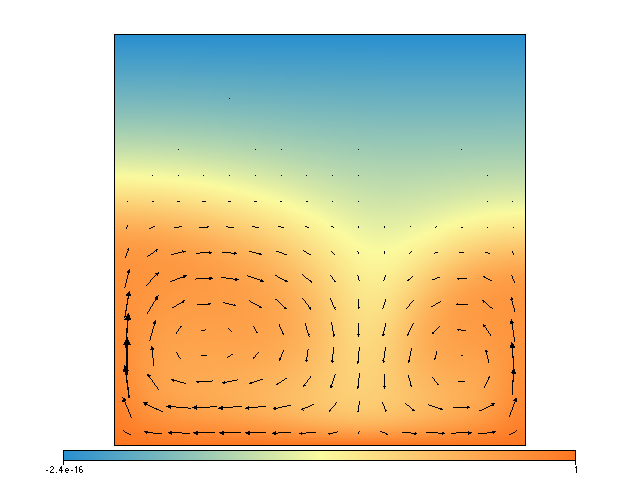

In [10]:
velmax = np.amax(velocityField.data[:])
if(velmax==0.0): velmax = 1.0
figtemp = glucifer.Figure()
tempminmax = fn.view.min_max(temperatureField)
figtemp.append( glucifer.objects.Surface(mesh, tempminmax) )
figtemp.append( glucifer.objects.VectorArrows(mesh, velocityField, scaling=0.1/velmax, arrowHead=0.2 ) )
figtemp.show()

Set up material parameters and functions
-----

In [11]:
# Rheology
eta0 = 1.0e-6
activationEnergy = 27.63102112
Ra = 1.e6
fn_viscosity = eta0 * fn.math.exp( activationEnergy / (temperatureField+1.) )

densityFn = Ra*temperatureField
# Define our vertical unit vector using a python tuple (this will be automatically converted to a function)
z_hat = ( 0.0, 1.0 )
# Now create a buoyancy force fn using the density.
buoyancyFn = z_hat*densityFn

**Plot the viscosity**



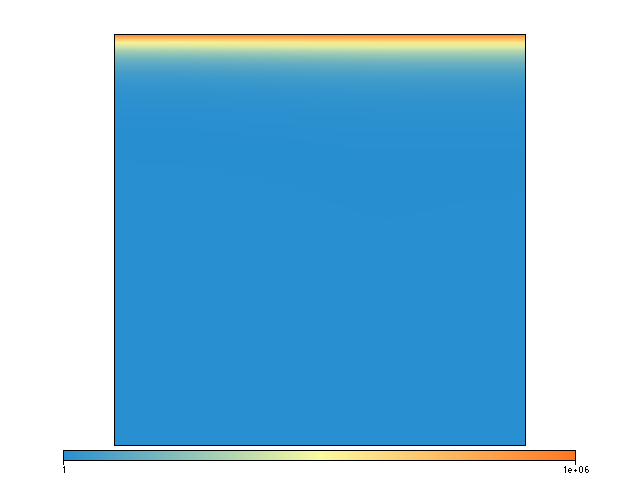

In [12]:
figEta = glucifer.Figure()
figEta.append( glucifer.objects.Surface(mesh, fn_viscosity) )
figEta.show()

System setup
-----

**Setup a Stokes system: advanced solver settings**

Set up parameters for the Stokes system solver. For PIC style integration, we include a swarm for the a PIC integration swarm is generated within. For gauss integration, simple do not include the swarm. Nearest neighbour is used where required.

In [13]:
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              fn_viscosity=fn.exception.SafeMaths(fn_viscosity), 
                              fn_bodyforce=buoyancyFn )

solver=uw.systems.Solver(stokesPIC)

**Create an advective diffusive system**


In [14]:
advDiff = uw.systems.AdvectionDiffusion( temperatureField, tempDotField, velocityField, fn_diffusivity=1., conditions=[tempBC,] )

Analysis tools
-----

**RMS velocity**

Set up integrals used to calculate the RMS velocity.

In [15]:
v2sum_integral  = uw.utils.Integral( mesh=mesh, fn=fn.math.dot(velocityField, velocityField) ) 
volume_integral = uw.utils.Integral( mesh=mesh, fn=1. )

**Nusselt number**


In [16]:
def FindNusseltNumber(temperatureField, linearMesh, xmax, zmax):
    tempgradField = temperatureField.fn_gradient
    vertGradField = tempgradField[1]
    BottomInt = 0.0
    GradValues = temperatureField.fn_gradient[1].evaluate(mesh.specialSets["MaxJ_VertexSet"])
    TopInt = sum(GradValues)
    for index in mesh.specialSets["MinJ_VertexSet"]:
        BottomInt += temperatureField.data[index]
    Nu = -zmax*TopInt/BottomInt
    return Nu[0]

Main simulation loop
-----

The main time stepping loop begins here. Before this the time and timestep are initialised to zero and the output statistics arrays are set up. Since this may be a continuation of the saved data with associated summary statistics then check if there are existing time values first. If there is existing data then add new simulation statistics after the existing data.

In [17]:
steps_prev = len(timeVal)
steps = 0
steps_end = 10
step_out = 25

# Set time to zero, unless we are loading from file.
try:
    time_start = timeVal[-1]
except:
    time_start = 0.0
print 'Begining at t = ',time_start,' after having completed ',steps_prev,' steps'

simtime = time_start

Begining at t =  0.0388546520796  after having completed  1000  steps


In [18]:
# Setup clock to calculate simulation CPU time.
start = time.clock()

# Perform steps_end steps.
rms_v, nu_no = 0.0, 0.0
while steps<steps_end:
    # Get solution for initial configuration.
    solver.solve()
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff.get_max_dt()
    if steps == 0:
        dt = 0.
    # Advect using this timestep size.
    advDiff.integrate(dt)
    
    # Calculate the RMS velocity.
    rms_v = math.sqrt(v2sum_integral.evaluate()[0]/volume_integral.evaluate()[0])
    nu_no = FindNusseltNumber(temperatureField, mesh, boxLength, boxHeight)
    
    # Increment time and store results.
    simtime += dt
    steps += 1
    vrmsVal.append( rms_v )
    timeVal.append( simtime )
    nuVal.append(nu_no)
                   
    if steps ==0 or steps % step_out == 0:
        print "steps = {:04d}; time = {:.6e}; vrms = {:6.2f}; nusselt = {:6.4f}; CPU = {:4.1f}s".format(
               steps, simtime, rms_v, nu_no, time.clock()-start)
        
v2sum = v2sum_integral.evaluate()
rms_v = rms_v = math.sqrt(v2sum_integral.evaluate()[0]/volume_integral.evaluate()[0])
# nu_no = -surface_Tgradient.integrate()[0] / basalT.integrate()[0]
nu_no = FindNusseltNumber(temperatureField, mesh, boxLength, boxHeight)

print "steps = {:04d}; time = {:.6e}; vrms = {:6.2f}; nusselt = {:6.4f}; CPU = {:4.1f}s".format(
               steps, simtime, rms_v, nu_no, time.clock()-start)


steps = 0010; time = 3.938317e-02; vrms =  35.92; nusselt = 1.0494; CPU = 10.8s


Post simulation analysis
-----

**Check CPU timing**

Output timing for calculation per simulation time step

In [19]:
if(steps!=steps_prev):
    avtime = (time.clock() - start)/float(steps)
else:
    avtime = 0.0

print "Average time per timestep = ",avtime," seconds over ", steps, " steps"

Average time per timestep =  1.0848109  seconds over  10  steps


Pre-run model took about $1.74$ seconds per timestep and was run for $13000$ timesteps for $Ra = 10^6$ for a $64\times64$ grid.

**Save data to files**

Save system summary data; $v_{rms}$ and the Nusselt number against time.


In [20]:
np.savetxt( outputPath+'ArrSumary.out', np.c_[timeVal, vrmsVal, nuVal], header="Time, VRMS, Nusselt" )

Save final temperature, velocity and pressure fields.

In [21]:
temperatureField.save(outputPath+'Arrhenius_T.out')
velocityField.save(outputPath+'Arrhenius_v.out')
pressureField.save(outputPath+'Arrhenius_P.out')

**Plot temperature field with velocity vectors overlaid**


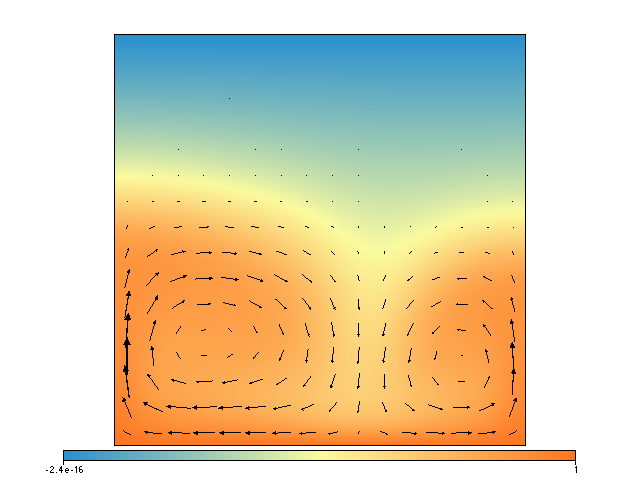

In [22]:
velmax = np.amax(velocityField.data[:])
figVT = glucifer.Figure()
figVT.append( glucifer.objects.Surface(mesh, temperatureField) )
figVT.append( glucifer.objects.VectorArrows(mesh, velocityField, scaling=0.1/velmax, arrowHead=0.2) )
figVT.show()

**Plot system summary information**

If the initial conditions were loaded up from a data file then these arrays will contain the saved data as well as results from the simulation just run.

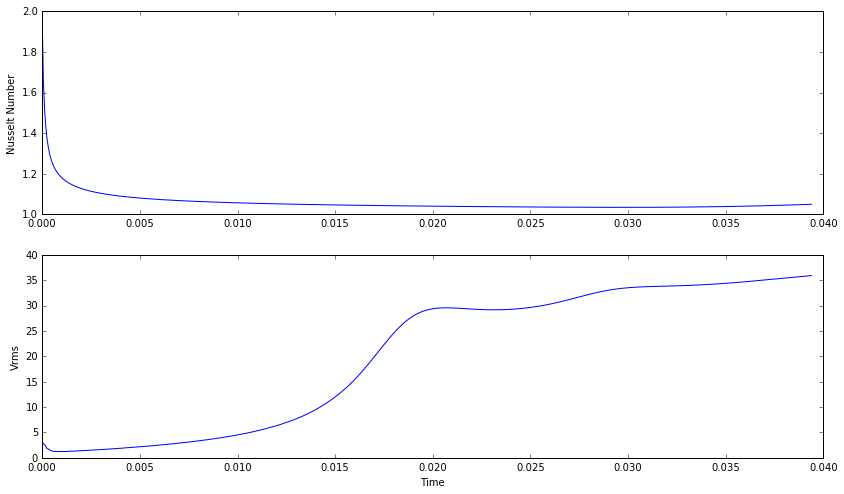

In [23]:
pylab.rcParams[ 'figure.figsize'] = 14, 8
pyplot.figure(1)
pyplot.subplot(211)
pyplot.plot(timeVal, nuVal)
pyplot.ylabel('Nusselt Number')

pyplot.subplot(212)
pyplot.plot(timeVal,vrmsVal)
pyplot.xlabel('Time')
pyplot.ylabel('Vrms')
pyplot.show()